Submitted by: Sampriti Mahapatra, MDS202433

# SMS Spam Classification - Model Training & MLflow Tracking

This notebook builds 3 benchmark models for SMS spam classification,
tracks experiments with MLflow, and registers models in the MLflow Model Registry.

## 1. Imports and Setup

In [27]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, roc_auc_score,
    confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# Configuration
PROJECT_DIR = '/Users/sampriti/Downloads/cmi/AML_2'
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Data

In [28]:
# Load the data splits
train_df = pd.read_csv(os.path.join(PROJECT_DIR, 'train.csv'))
val_df = pd.read_csv(os.path.join(PROJECT_DIR, 'validation.csv'))
test_df = pd.read_csv(os.path.join(PROJECT_DIR, 'test.csv'))

print(f"Training set:   {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set:       {test_df.shape}")

# Display class distribution
for name, df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    counts = df['label'].value_counts()
    print(f"\n{name}: ham={counts['ham']}, spam={counts['spam']}")

Training set:   (3898, 3)
Validation set: (835, 3)
Test set:       (836, 3)

Train: ham=3375, spam=523

Validation: ham=723, spam=112

Test: ham=724, spam=112


In [29]:
# Encode labels: ham=0, spam=1
le = LabelEncoder()
le.fit(['ham', 'spam'])  # ham=0, spam=1

y_train = le.transform(train_df['label'])
y_val = le.transform(val_df['label'])
y_test = le.transform(test_df['label'])

print(f"Label encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"Training: {sum(y_train==0)} ham, {sum(y_train==1)} spam")

Label encoding: {np.str_('ham'): np.int64(0), np.str_('spam'): np.int64(1)}
Training: 3375 ham, 523 spam


## 3. Feature Extraction with TF-IDF

In [30]:
# Create TF-IDF features from cleaned_message
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train = tfidf.fit_transform(train_df['cleaned_message'].fillna(''))
X_val = tfidf.transform(val_df['cleaned_message'].fillna(''))
X_test = tfidf.transform(test_df['cleaned_message'].fillna(''))

print(f"TF-IDF vocabulary size: {len(tfidf.vocabulary_)}")
print(f"Training matrix shape:   {X_train.shape}")
print(f"Validation matrix shape: {X_val.shape}")
print(f"Test matrix shape:       {X_test.shape}")

TF-IDF vocabulary size: 5000
Training matrix shape:   (3898, 5000)
Validation matrix shape: (835, 5000)
Test matrix shape:       (836, 5000)


## 4. Setup MLflow Experiment

In [31]:
# Set MLflow tracking URI to local directory
mlflow.set_tracking_uri(os.path.join(PROJECT_DIR, 'mlruns'))

# Create/set experiment
experiment_name = "SMS_Spam_Classification"
mlflow.set_experiment(experiment_name)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {experiment_name}")

MLflow tracking URI: /Users/sampriti/Downloads/cmi/AML_2/mlruns
Experiment: SMS_Spam_Classification


## 5. Helper Function for Training and Logging

In [32]:
def train_and_log_model(model, model_name, X_train, y_train, X_val, y_val,
                         X_test, y_test, tfidf_params, registered_model_name):
    """
    Train a model, evaluate on val and test sets, log everything to MLflow,
    and register the model.
    """
    with mlflow.start_run(run_name=model_name) as run:
        # --- Log parameters ---
        model_params = model.get_params()
        for param_name, param_value in model_params.items():
            mlflow.log_param(f"model_{param_name}", param_value)

        for param_name, param_value in tfidf_params.items():
            mlflow.log_param(f"tfidf_{param_name}", param_value)

        mlflow.log_param("model_type", model_name)

        # --- Train model ---
        model.fit(X_train, y_train)

        # --- Predictions ---
        y_val_pred = model.predict(X_val)
        y_val_proba = model.predict_proba(X_val)[:, 1]

        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # --- Compute metrics on VALIDATION set ---
        val_metrics = {
            "val_accuracy": accuracy_score(y_val, y_val_pred),
            "val_precision": precision_score(y_val, y_val_pred),
            "val_recall": recall_score(y_val, y_val_pred),
            "val_f1": f1_score(y_val, y_val_pred),
            "val_aucpr": average_precision_score(y_val, y_val_proba),
            "val_roc_auc": roc_auc_score(y_val, y_val_proba),
        }

        # --- Compute metrics on TEST set ---
        test_metrics = {
            "test_accuracy": accuracy_score(y_test, y_test_pred),
            "test_precision": precision_score(y_test, y_test_pred),
            "test_recall": recall_score(y_test, y_test_pred),
            "test_f1": f1_score(y_test, y_test_pred),
            "test_aucpr": average_precision_score(y_test, y_test_proba),
            "test_roc_auc": roc_auc_score(y_test, y_test_proba),
        }

        # Log all metrics
        mlflow.log_metrics(val_metrics)
        mlflow.log_metrics(test_metrics)

        # --- Artifacts: Confusion Matrix ---
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        ConfusionMatrixDisplay.from_predictions(
            y_val, y_val_pred, display_labels=['ham', 'spam'], ax=axes[0], cmap='Blues'
        )
        axes[0].set_title(f'{model_name} - Validation Set')

        ConfusionMatrixDisplay.from_predictions(
            y_test, y_test_pred, display_labels=['ham', 'spam'], ax=axes[1], cmap='Blues'
        )
        axes[1].set_title(f'{model_name} - Test Set')

        plt.tight_layout()
        cm_path = os.path.join(PROJECT_DIR, f'{model_name}_confusion_matrix.png')
        plt.savefig(cm_path, dpi=150, bbox_inches='tight')
        plt.show()
        mlflow.log_artifact(cm_path)
        os.remove(cm_path)

        # --- Artifacts: Classification Report ---
        report = classification_report(y_test, y_test_pred, target_names=['ham', 'spam'])
        report_path = os.path.join(PROJECT_DIR, f'{model_name}_classification_report.txt')
        with open(report_path, 'w') as f:
            f.write(f"Classification Report - {model_name}\n")
            f.write(report)
        mlflow.log_artifact(report_path)
        os.remove(report_path)

        # --- Log and Register Model ---
        mlflow.sklearn.log_model(
            model,
            artifact_path="model",
            registered_model_name=registered_model_name
        )

        # --- Print summary ---
        print(f"Model: {model_name}")
        print(f"Run ID: {run.info.run_id}")
        print(f"\nValidation Metrics:")
        for k, v in val_metrics.items():
            print(f"  {k}: {v:.4f}")
        print(f"\nTest Metrics:")
        for k, v in test_metrics.items():
            print(f"  {k}: {v:.4f}")

        return run.info.run_id, val_metrics, test_metrics

## 6. Model 1: Multinomial Naive Bayes

Naive Bayes is the classic baseline for text classification. It assumes feature independence
and works naturally with TF-IDF word counts. Expected to perform well on spam detection
due to the distinctive word distributions in spam vs ham messages.

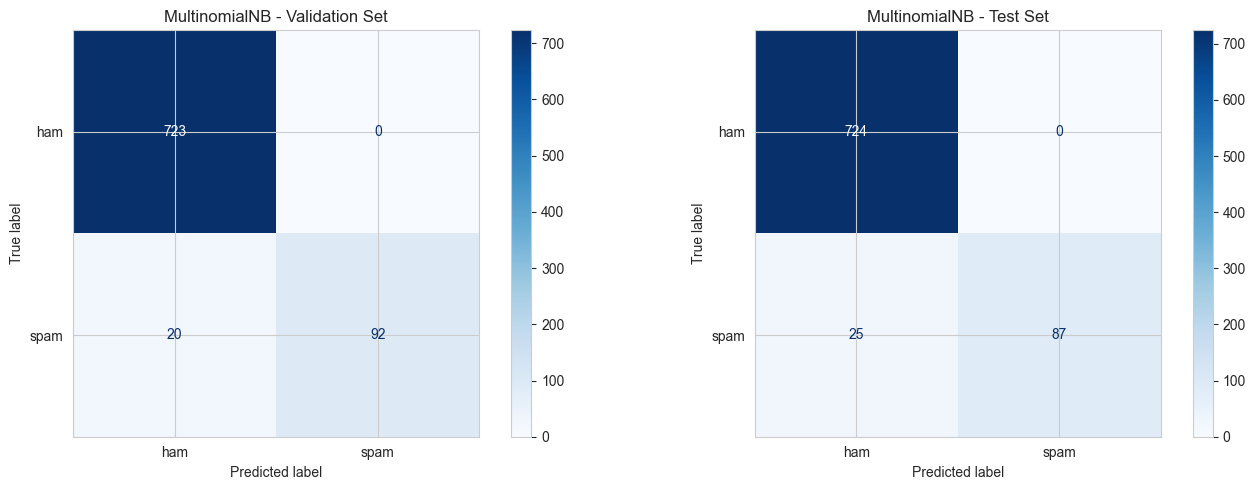

2026/02/16 16:13:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: MultinomialNB
Run ID: 5d8dba502dab45d8b75661c3885eaa09

Validation Metrics:
  val_accuracy: 0.9760
  val_precision: 1.0000
  val_recall: 0.8214
  val_f1: 0.9020
  val_aucpr: 0.9826
  val_roc_auc: 0.9903

Test Metrics:
  test_accuracy: 0.9701
  test_precision: 1.0000
  test_recall: 0.7768
  test_f1: 0.8744
  test_aucpr: 0.9712
  test_roc_auc: 0.9843


Registered model 'MultinomialNB_SMS_Spam' already exists. Creating a new version of this model...
Created version '3' of model 'MultinomialNB_SMS_Spam'.


In [33]:
# TF-IDF params for logging
tfidf_params = {
    "max_features": 5000,
    "ngram_range": "(1, 2)",
    "min_df": 2,
    "max_df": 0.95,
    "sublinear_tf": True
}

# Model 1: Multinomial Naive Bayes
nb_model = MultinomialNB(alpha=1.0, fit_prior=True)

nb_run_id, nb_val_metrics, nb_test_metrics = train_and_log_model(
    model=nb_model,
    model_name="MultinomialNB",
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    tfidf_params=tfidf_params,
    registered_model_name="MultinomialNB_SMS_Spam"
)

## 7. Model 2: Logistic Regression

Logistic Regression is a strong linear discriminative classifier. When combined with TF-IDF,
it often outperforms Naive Bayes. Its coefficients are interpretable -- we can see which words
contribute most to the spam prediction.

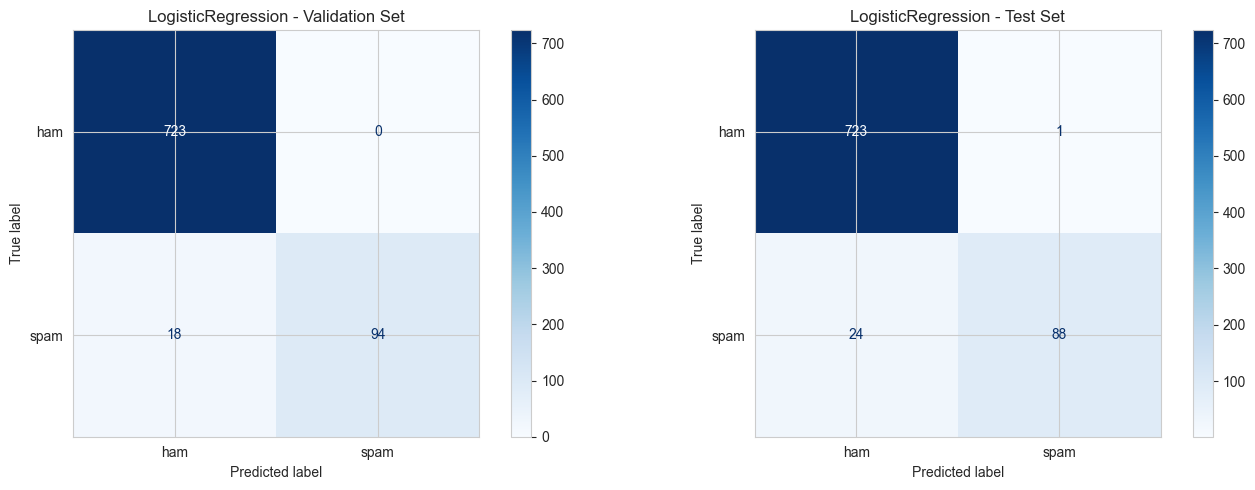

2026/02/16 16:13:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: LogisticRegression
Run ID: 62d9e0f913644a7fbcc8a94c76992c7d

Validation Metrics:
  val_accuracy: 0.9784
  val_precision: 1.0000
  val_recall: 0.8393
  val_f1: 0.9126
  val_aucpr: 0.9842
  val_roc_auc: 0.9933

Test Metrics:
  test_accuracy: 0.9701
  test_precision: 0.9888
  test_recall: 0.7857
  test_f1: 0.8756
  test_aucpr: 0.9742
  test_roc_auc: 0.9888


Registered model 'LogisticRegression_SMS_Spam' already exists. Creating a new version of this model...
Created version '3' of model 'LogisticRegression_SMS_Spam'.


In [34]:
# Model 2: Logistic Regression
lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    solver='lbfgs',
    random_state=RANDOM_STATE
)

lr_run_id, lr_val_metrics, lr_test_metrics = train_and_log_model(
    model=lr_model,
    model_name="LogisticRegression",
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    tfidf_params=tfidf_params,
    registered_model_name="LogisticRegression_SMS_Spam"
)

## 8. Model 3: Random Forest

Random Forest is a non-linear ensemble method that can capture feature interactions
missed by linear models. It serves as a contrast to the two linear models above,
demonstrating whether non-linear patterns exist in the TF-IDF feature space.

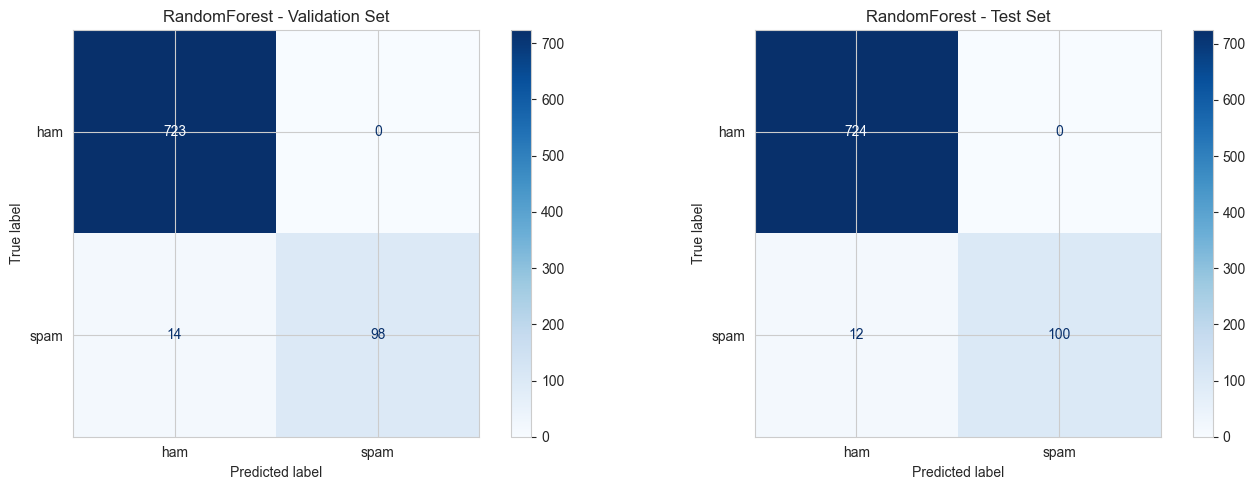

2026/02/16 16:13:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: RandomForest
Run ID: 72e9798fe29d434e8974848839341597

Validation Metrics:
  val_accuracy: 0.9832
  val_precision: 1.0000
  val_recall: 0.8750
  val_f1: 0.9333
  val_aucpr: 0.9747
  val_roc_auc: 0.9880

Test Metrics:
  test_accuracy: 0.9856
  test_precision: 1.0000
  test_recall: 0.8929
  test_f1: 0.9434
  test_aucpr: 0.9829
  test_roc_auc: 0.9890


Registered model 'RandomForest_SMS_Spam' already exists. Creating a new version of this model...
Created version '3' of model 'RandomForest_SMS_Spam'.


In [35]:
# Model 3: Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_run_id, rf_val_metrics, rf_test_metrics = train_and_log_model(
    model=rf_model,
    model_name="RandomForest",
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    tfidf_params=tfidf_params,
    registered_model_name="RandomForest_SMS_Spam"
)

## 9. Compare All Models


Model Comparison:
             Model                           Run ID  Val AUCPR   Val F1  Test AUCPR  Test F1
     MultinomialNB 5d8dba502dab45d8b75661c3885eaa09   0.982585 0.901961    0.971201 0.874372
LogisticRegression 62d9e0f913644a7fbcc8a94c76992c7d   0.984235 0.912621    0.974242 0.875622
      RandomForest 72e9798fe29d434e8974848839341597   0.974690 0.933333    0.982865 0.943396


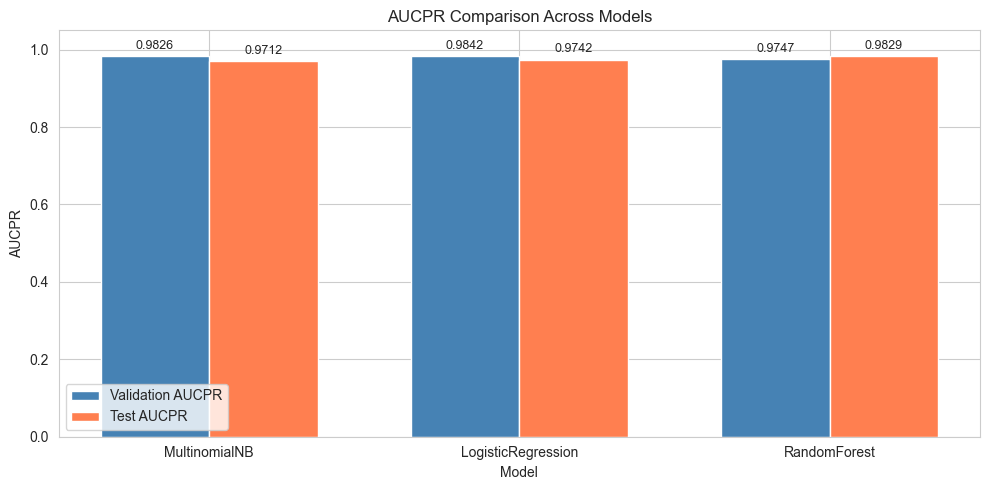

In [36]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['MultinomialNB', 'LogisticRegression', 'RandomForest'],
    'Run ID': [nb_run_id, lr_run_id, rf_run_id],
    'Val AUCPR': [nb_val_metrics['val_aucpr'], lr_val_metrics['val_aucpr'], rf_val_metrics['val_aucpr']],
    'Val F1': [nb_val_metrics['val_f1'], lr_val_metrics['val_f1'], rf_val_metrics['val_f1']],
    'Test AUCPR': [nb_test_metrics['test_aucpr'], lr_test_metrics['test_aucpr'], rf_test_metrics['test_aucpr']],
    'Test F1': [nb_test_metrics['test_f1'], lr_test_metrics['test_f1'], rf_test_metrics['test_f1']],
})

print("\nModel Comparison:")
print(results.to_string(index=False))

# Plot AUCPR comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(results))
width = 0.35
bars1 = ax.bar(x - width/2, results['Val AUCPR'], width, label='Validation AUCPR', color='steelblue')
bars2 = ax.bar(x + width/2, results['Test AUCPR'], width, label='Test AUCPR', color='coral')
ax.set_xlabel('Model')
ax.set_ylabel('AUCPR')
ax.set_title('AUCPR Comparison Across Models')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.set_ylim(0, 1.05)

for bar in list(bars1) + list(bars2):
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 10. AUCPR for Each Registered Model

Retrieve AUCPR from the MLflow Model Registry for each registered model.

In [37]:
# Initialize MLflow client
client = MlflowClient()

registered_models = [
    "MultinomialNB_SMS_Spam",
    "LogisticRegression_SMS_Spam",
    "RandomForest_SMS_Spam"
]

print("AUCPR for Each Registered Model:")

for model_name in registered_models:
    # Get the latest version of the registered model
    versions = client.search_model_versions(f"name='{model_name}'")

    if versions:
        latest_version = versions[0]
        run_id = latest_version.run_id
        version_num = latest_version.version

        # Get metrics from the associated run
        run = client.get_run(run_id)
        val_aucpr = run.data.metrics.get('val_aucpr', 'N/A')
        test_aucpr = run.data.metrics.get('test_aucpr', 'N/A')

        print(f"\nModel: {model_name} (Version {version_num})")
        print(f"  Run ID:     {run_id}")
        if isinstance(val_aucpr, float):
            print(f"  Val AUCPR:  {val_aucpr:.4f}")
        else:
            print(f"  Val AUCPR:  {val_aucpr}")
        if isinstance(test_aucpr, float):
            print(f"  Test AUCPR: {test_aucpr:.4f}")
        else:
            print(f"  Test AUCPR: {test_aucpr}")
    else:
        print(f"\nModel: {model_name} -- No versions found")

AUCPR for Each Registered Model:

Model: MultinomialNB_SMS_Spam (Version 3)
  Run ID:     5d8dba502dab45d8b75661c3885eaa09
  Val AUCPR:  0.9826
  Test AUCPR: 0.9712

Model: LogisticRegression_SMS_Spam (Version 3)
  Run ID:     62d9e0f913644a7fbcc8a94c76992c7d
  Val AUCPR:  0.9842
  Test AUCPR: 0.9742

Model: RandomForest_SMS_Spam (Version 3)
  Run ID:     72e9798fe29d434e8974848839341597
  Val AUCPR:  0.9747
  Test AUCPR: 0.9829


In [38]:
# Commit the train notebook to git
os.chdir(PROJECT_DIR)
!git add train.ipynb
!git commit -a -m "Add train.ipynb with 3 benchmark models tracked by MLflow"
!git log --oneline

[main 9815a7e] Add train.ipynb with 3 benchmark models tracked by MLflow
 1 file changed, 93 insertions(+), 120 deletions(-)
9815a7e (HEAD -> main) Add train.ipynb with 3 benchmark models tracked by MLflow
f97c3d1 Version 2: data splits with RANDOM_STATE=123
0edda6c Version 1: data splits with RANDOM_STATE=42
6661081 Add train.ipynb with 3 benchmark models tracked by MLflow
564de3c Add Google Drive as DVC remote storage
eaf8eeb configure google drive as dvc remote storage
bff705e configure google drive as dvc remote storage
c4f01f1 Version 2: data splits with RANDOM_STATE=123
d3baad4 Version 1: data splits with RANDOM_STATE=42
4a140a4 Initial commit: project setup with DVC initialization
c88235d Add train.ipynb with 3 benchmark models tracked by MLflow
016ac01 Add Google Drive as DVC remote storage
70d0695 (tag: v2) Version 2: data splits with RANDOM_STATE=123
d9bca26 (tag: v1) Version 1: data splits with RANDOM_STATE=42
2b3cda5 Initial commit: project setup with DVC initialization
